# Horizontally-layered media ray-tracing

3D traveltimes from 1D model.  
Computations are based on the offset-traveltime parametric equations:
$$ \Large
\begin{cases}
x = - \sum_{i=1}^{N} z_i \frac{d q_i}{dp} \\
t = \sum_{i=1}^{N} x_i p + z_i q_i
\end{cases}
$$  
where $x,t$ is the one-way offset-traveltime pair for a stack of $N$ layers for a given horizontal slowness $p$,  
$\mathbf{p_i} = (p,q_i)$ is the slowness vector in $i$-th layer,  
$z_i$ is the thickness of the $i$-th layer.  

Vertical slowness in $i$-th layer is given by
$$
q_i = \sqrt{\frac{1}{v_i^2} - p^2},
$$
where $v_i$ is the wave velocity in $i$-th layer. Choosing $v_p$ or $v_s$, one get the corresponding traveltimes.  

In order to get the converted waves, down-going ray is that of the P-wave, and up-going is that of the S-wave. Snell's law is honored by keeping $p$ constant for a given ray.

TODO:  
1. Get reflectivities implemented (RT-coefficients at each interface)
2. Geometrical spreading
3. Convolution with a wavelet to get a synthetic shot gather
4. Implemnt post-critical reflections

In [19]:
import bruges as b
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import scipy.interpolate as scpi
%matplotlib inline

In [20]:
def vertical_slowness(p, v):
    svec = np.tile(1 / v**2,(p.size,1)).T
    pvec = np.tile(- p**2,(v.size,1))
    q = np.sqrt(svec + pvec)
    dq = - p * (q)**(-1)
    return q, dq

In [21]:
def max_slowness(v):
    p = 1/np.max(v)
    return p

In [22]:
def traveltimes(vp, vs, dz_layers, x_rec, n_iter = 3):
    n_offsets = x_rec.size
    X = np.zeros((vp.size,x_rec.size))
    Xi = np.zeros((vp.size,x_rec.size))
    T = np.zeros((vp.size,x_rec.size))
    Ti = np.zeros((vp.size,x_rec.size))
    
    XPS = np.zeros((vp.size,x_rec.size))
    TPS = np.zeros((vp.size,x_rec.size))
    XPSi = np.zeros((vp.size,x_rec.size))
    TPSi = np.zeros((vp.size,x_rec.size))
    
    for i in range(vp.size):
        vpi = vp[:i+1]
        vsi = vs[:i+1]
        dzi = dz_layers[:i+1]
        pmax = max_slowness(vpi) * .9999
        pvec = np.linspace(0,pmax,n_offsets)
        
        for j in range(n_iter):
            qA, dqA = vertical_slowness(pvec,vpi)
            # P-wave
            x = - (dzi * dqA.T).T
            t = x * pvec + (qA.T * dzi).T
            x_total = 2* np.sum(x, axis=0)
            t_total = 2* np.sum(t, axis=0)
            
            
            # PS-wave
            qAS, dqAS = vertical_slowness(pvec,vsi)
            xS = - (dzi * dqAS.T).T
            tS = xS * pvec + (qAS.T * dzi).T
            xPS_total = x_total/2 + np.sum(xS, axis=0)
            tPS_total = t_total/2 + np.sum(tS, axis=0)

            x_reg = np.linspace(0,np.max(x_total),n_offsets)
            xPS_reg = np.linspace(0,np.max(xPS_total),n_offsets)
            pvec = scpi.interp1d(x_total, pvec, kind='slinear')(x_reg)
            
        if np.max(x_rec) <= np.max(x_reg) and np.max(x_rec) <= np.max(xPS_reg):
            tint = scpi.interp1d(x_reg, t_total, kind='cubic')(x_rec)
            tPSint = scpi.interp1d(xPS_total, tPS_total, kind='cubic')(x_rec)
            xi = x_rec;
            xPSi = x_rec;
        elif np.max(x_rec) < np.max(x_reg) and np.max(x_rec) > np.max(xPS_reg):
            print("maximum PS offset is smaller than desired")
            tint = scpi.interp1d(x_reg, t_total, kind='cubic')(x_rec)
            tPSint = scpi.interp1d(xPS_total, tPS_total, kind='cubic')(xPS_reg)
            xi = x_rec;
            xPSi = xPS_reg;   
        elif np.max(x_rec) > np.max(x_reg) and np.max(x_rec) > np.max(xPS_reg):
            print("maximum PP and PS offsets are smaller than desired")
            tint = scpi.interp1d(x_reg, t_total, kind='cubic')(x_reg)
            tPSint = scpi.interp1d(xPS_total, tPS_total, kind='cubic')(xPS_reg)
            xi = x_reg;
            xPSi = xPS_reg;
        
        X[i,:] = x_reg
        T[i,:] = t_total
        
        Xi[i,:] = xi
        Ti[i,:] = tint
        
        XPS[i,:] = xPS_total
        TPS[i,:] = tPS_total
        
        XPSi[i,:] = xPSi
        TPSi[i,:] = tPSint
        
    return X, T, Xi, Ti, XPS, TPS, XPSi, TPSi


In [23]:
# arrays of interval velocities and density
vp = np.array([1600, 2000, 2500, 2400, 2600, 2500])
vs = np.array([400, 1000, 1250, 1400, 2000, 1900])
#rho = np.array([1200, 2300, 2100, 2500, 3000, 3600])
dz = (.75 * np.random.random_sample((vp.size,)) + .25) * 1000
z_total = np.sum(dz)

In [24]:
x_rec = np.arange(0,z_total*4,25)
x, t, xi, ti, xPS, tPS, xPSi, tPSi = traveltimes(vp, vs, dz, x_rec)

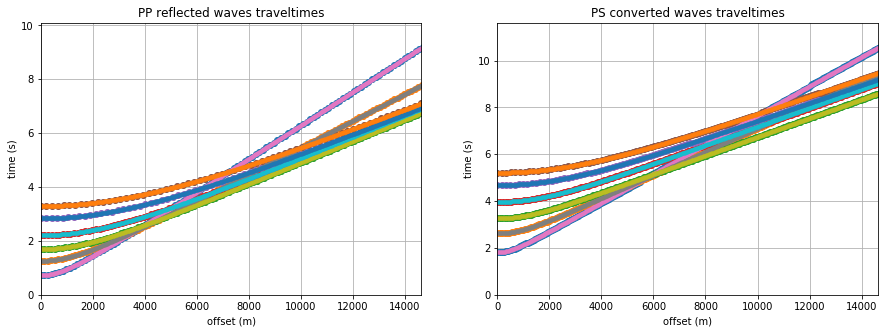

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(x.T,t.T,'o',xi.T,ti.T,'.')
ax1.set_xlim(0,np.max(x_rec))
ax1.set_ylim(0,np.max(ti)*1.1)
ax1.set_title('PP reflected waves traveltimes')
ax1.set_xlabel('offset (m)')
ax1.set_ylabel('time (s)')
ax1.grid(True)

ax2.plot(xPS.T,tPS.T,'o',xPSi.T,tPSi.T,'.')
ax2.set_xlim(0,np.max(x_rec))
ax2.set_ylim(0,np.max(tPSi)*1.1)
ax2.set_title('PS converted waves traveltimes')
ax2.set_xlabel('offset (m)')
ax2.set_ylabel('time (s)')
ax2.grid(True)